### DataSet и Dataloader

#### Imports

In [ ]:
import torch
import torchvision

from torchvision. datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split

# вспомогательные библиотеки
import os
import json
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

#### Загрузка и создание учебных данных

##### Для классификации

In [ ]:
import struct
import sys

from array import array
from os import path

In [ ]:
train_dataset = torchvision.datasets.MNIST(root='/content/sample_data/', train=True, download=True)
test_dataset =torchvision.datasets.MNIST(root='/content/sample_data/', train=False, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting /content/sample_data/MNIST/raw/train-images-idx3-ubyte.gz to /content/sample_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 505kB/s]


Extracting /content/sample_data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/sample_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.82MB/s]


Extracting /content/sample_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/sample_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.36MB/s]

Extracting /content/sample_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/sample_data/MNIST/raw



In [ ]:
def read(dataset):
    if dataset == 'training':
        path_img = '/content/sample_data/MNIST/raw/train-images-idx3-ubyte'
        path_lbl = '/content/sample_data/MNIST/raw/train-labels-idx1-ubyte'

    elif dataset == 'testing':
        path_img = '/content/sample_data/MNIST/raw/t10k-images-idx3-ubyte'
        path_lbl = '/content/sample_data/MNIST/raw/t10k-labels-idx1-ubyte'

    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    with open(path_lbl, 'rb') as f_lable:
        _, size = struct.unpack('>II', f_lable.read(8))
        lbl = array('b', f_lable.read())

    with open(path_img, 'rb') as f_img:
        _, size, rows, cols = struct.unpack('>IIII', f_img.read(16))
        img = array('B', f_img.read())

    return lbl, img, size, rows, cols

In [ ]:
def write_dataset(labels, data, size, rows, cols, output_dir):

    classes = {i: f'class_{i}' for i in range(10)}

    output_dirs = [
        path.join(output_dir, classes[i])
        for i in range(10)
    ]
    for dir in output_dirs:
        if not path.exists(dir):
            os.makedirs(dir)

    # write data
    for (i, label) in enumerate(labels):
        output_filename = path.join(output_dirs[label], str(i) + '.jpg')
        print('writing ' + output_filename)

        with open(output_filename, 'wb') as h:
            data_i = [
                data[(i*rows*cols + j*cols) : (i*rows*cols + (j+1)*cols)]
                for j in range(rows)
            ]
            data_array = np.asarray(data_i)

            im = Image.fromarray(data_array)
            im.save(output_filename)

In [ ]:
output_path = '/content/mnist'

In [ ]:
for dataset in ['training', 'testing']:
    write_dataset(*read(dataset), path.join(output_path, dataset))

Streaming output truncated to the last 5000 lines.
writing /content/mnist/testing/class_3/5000.jpg
writing /content/mnist/testing/class_9/5001.jpg
writing /content/mnist/testing/class_9/5002.jpg
writing /content/mnist/testing/class_8/5003.jpg
writing /content/mnist/testing/class_4/5004.jpg
writing /content/mnist/testing/class_1/5005.jpg
writing /content/mnist/testing/class_0/5006.jpg
writing /content/mnist/testing/class_6/5007.jpg
writing /content/mnist/testing/class_0/5008.jpg
writing /content/mnist/testing/class_9/5009.jpg
writing /content/mnist/testing/class_6/5010.jpg
writing /content/mnist/testing/class_8/5011.jpg
writing /content/mnist/testing/class_6/5012.jpg
writing /content/mnist/testing/class_1/5013.jpg
writing /content/mnist/testing/class_1/5014.jpg
writing /content/mnist/testing/class_9/5015.jpg
writing /content/mnist/testing/class_8/5016.jpg
writing /content/mnist/testing/class_9/5017.jpg
writing /content/mnist/testing/class_2/5018.jpg
writing /content/mnist/testing/class_

##### Для Регрессии

In [ ]:
if not os.path.isdir("dataset"):
    os.mkdir('dataset')

img = np.random.randint(0, 50, [100000, 64, 64], dtype=np.uint8)
square = np.random.randint(100, 200, [100000, 15, 15], dtype=np.uint8)

coords = np.empty([100000, 2])

data = {}

for i in range(img.shape[0]):
    x = np.random.randint(20, 44)
    y = np.random.randint(20, 44)

    img[i, (y-7):(y + 8), (x - 7):(x + 8)] = square[i]

    coords[i] = [y, x]

    name_img = f'img{i}.jpeg'
    path_img = os.path.join('dataset/', name_img)

    image = Image.fromarray(img[i])
    image.save(path_img)

    data[name_img] = [y, x]

with open('dataset/coords.json', 'w') as f:
    json.dump(data, f, indent=2)

# os.rmdir('dataset/.ipymb_checpoints')

#### Mnist для задачи классификации

##### Пользовательский класс для классификации

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform

        self.len_dataset = 0 # длина датасет
        self.data_list = [] # список кортежей путей до файла и позиции в onehot векторе

        # итерируемся по папке с основными файлами
        for path_dir, dir_list, file_list in os.walk(path):
            if path_dir == path:
                self.classes = sorted(dir_list)
                self.class_to_idx = {
                    cls_name: i for i, cls_name in enumerate(self.classes)
                    }
                continue

            cls = path_dir.split('/')[-1]

            for name_file in file_list:
                file_path = os.path.join(path_dir, name_file)
                self.data_list.append((file_path, self.class_to_idx[cls]))

            self.len_dataset += len(file_list)

    def __len__(self):
        return self.len_dataset

    def __getitem__(self, index):
        file_path, target = self.data_list[index]
        sample = np.array(Image.open(file_path))

        if self.transform is not None:
            sample = self.transform(sample)

        return sample, target

In [ ]:
# объяснение работы цикла в __init__
for path, dir_list, file_list in os.walk('/content/mnist/training'):
    print(f'Путь к папке - {path}')
    print(f'    -- кол-во папок {len(dir_list)}')
    print(f'    -- кол-во файлов {len(file_list)}')

Путь к папке - /content/mnist/training
    -- кол-во папок 10
    -- кол-во файлов 0
Путь к папке - /content/mnist/training/class_5
    -- кол-во папок 0
    -- кол-во файлов 5421
Путь к папке - /content/mnist/training/class_2
    -- кол-во папок 0
    -- кол-во файлов 5958
Путь к папке - /content/mnist/training/class_9
    -- кол-во папок 0
    -- кол-во файлов 5949
Путь к папке - /content/mnist/training/class_7
    -- кол-во папок 0
    -- кол-во файлов 6265
Путь к папке - /content/mnist/training/class_4
    -- кол-во папок 0
    -- кол-во файлов 5842
Путь к папке - /content/mnist/training/class_0
    -- кол-во папок 0
    -- кол-во файлов 5923
Путь к папке - /content/mnist/training/class_1
    -- кол-во папок 0
    -- кол-во файлов 6742
Путь к папке - /content/mnist/training/class_3
    -- кол-во папок 0
    -- кол-во файлов 6131
Путь к папке - /content/mnist/training/class_6
    -- кол-во папок 0
    -- кол-во файлов 5918
Путь к папке - /content/mnist/training/class_8
    -- кол-во

In [ ]:
# объяснение работы цикла в __init__
for path, dir_list, file_list in os.walk('/content/mnist/testing'):
    print(f'Путь к папке - {path}')
    print(f'    -- кол-во папок {len(dir_list)}')
    print(f'    -- кол-во файлов {len(file_list)}')

Путь к папке - /content/mnist/testing
    -- кол-во папок 10
    -- кол-во файлов 0
Путь к папке - /content/mnist/testing/class_5
    -- кол-во папок 0
    -- кол-во файлов 892
Путь к папке - /content/mnist/testing/class_2
    -- кол-во папок 0
    -- кол-во файлов 1032
Путь к папке - /content/mnist/testing/class_9
    -- кол-во папок 0
    -- кол-во файлов 1009
Путь к папке - /content/mnist/testing/class_7
    -- кол-во папок 0
    -- кол-во файлов 1028
Путь к папке - /content/mnist/testing/class_4
    -- кол-во папок 0
    -- кол-во файлов 982
Путь к папке - /content/mnist/testing/class_0
    -- кол-во папок 0
    -- кол-во файлов 980
Путь к папке - /content/mnist/testing/class_1
    -- кол-во папок 0
    -- кол-во файлов 1135
Путь к папке - /content/mnist/testing/class_3
    -- кол-во папок 0
    -- кол-во файлов 1010
Путь к папке - /content/mnist/testing/class_6
    -- кол-во папок 0
    -- кол-во файлов 958
Путь к папке - /content/mnist/testing/class_8
    -- кол-во папок 0
    --

In [ ]:
train_data = MNISTDataset('/content/mnist/training')
test_data = MNISTDataset('/content/mnist/testing')

In [ ]:
train_data.classes

['class_0',
 'class_1',
 'class_2',
 'class_3',
 'class_4',
 'class_5',
 'class_6',
 'class_7',
 'class_8',
 'class_9']

In [ ]:
# проверяем свойство class_to_idx
train_data.class_to_idx

{'class_0': 0,
 'class_1': 1,
 'class_2': 2,
 'class_3': 3,
 'class_4': 4,
 'class_5': 5,
 'class_6': 6,
 'class_7': 7,
 'class_8': 8,
 'class_9': 9}

In [ ]:
for cls, one_hot_position in train_data.class_to_idx.items():
    one_hot_vector = [(i == one_hot_position)*1 for i in range(10)]
    print(f'\033[32m{cls}\033[0m => \033[34m{one_hot_vector}\033[m')

class_0 => [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
class_1 => [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
class_2 => [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
class_3 => [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
class_4 => [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
class_5 => [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
class_6 => [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
class_7 => [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
class_8 => [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
class_9 => [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [ ]:
# проверка метода len
print(f'Длина тренировачных данных: {len(train_data)}')
print(f'Длина тестовых данных: {len(test_data)}')

Длина тренировачных данных: 60000
Длина тестовых данных: 10000


In [ ]:
# проверка магического метода getitem на train_data
# поскольку len = 60000, то index => 0 ... 59999
train_data[2453]  # out: (np.array, one_hot_position)

(array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   8,   2,   0,
           2,   7,   0,   0,   2,  10,   0,   6,  10,   0,   7,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   6,   0,   0,   1,
           5,   0,   0,  18,   0,   3,   0,   0,   7,  10,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,  20,   0,   0,  17,   5,
           0,   0,   8,   0,   0,  11,   2,   5,   9,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   6,   6,   0,   0,
           8,   6,   0,   0,  12,   1,   0,   6,   0,   0,  12,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   6,   0,  10,   0,
           1,   0,   1,  10,   0,   0,   9,   0,   0,   9,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   7,   2,   0,   0,  11,
         222, 224,  10,   0,   7,   9,   9,   0,   0,   9,   9,   0,   0,
           0

Класс: class_5


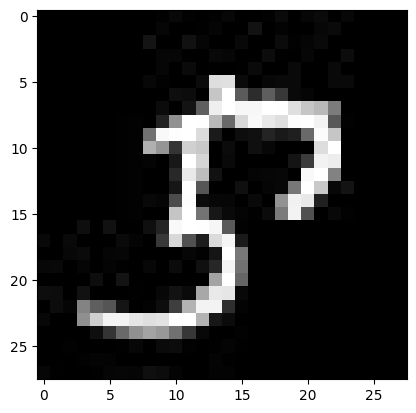

In [ ]:
# проверим, соответствует ли полученное изображение соответствующему классу
img, one_hot_position = train_data[2453]

cls = train_data.classes[one_hot_position]
print(f'Класс: {cls}')
plt.imshow(img, cmap='gray')

In [ ]:
# разобьем датасет на трейновую и валидационную части
train_data, val_data = random_split(train_data, [0.8, 0.2])

In [ ]:
print(f'Длина тренировочных данных: {len(train_data)}')
print(f'Длина валидационных данных: {len(val_data)}')
print(f'Длина тестовых данных: {len(test_data)}')

Длина тренировочных данных: 48000
Длина валидационных данных: 12000
Длина тестовых данных: 10000


In [ ]:
# Разобьем данные на батчи
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [ ]:
for i, (samples, target) in enumerate(train_loader):
    if i < 3:
        print(f'Номер batch: {i+1}')
        print(f'    размер samples: {samples.shape}')
        print(f'    размер target: {target.shape}')

print('\n    ..........    \n')
print(f'Номер batch: {i+1}')
print(f'    размер samples: {samples.shape}')
print(f'    размер target: {target.shape}')

Номер batch: 1
    размер samples: torch.Size([16, 28, 28])
    размер target: torch.Size([16])
Номер batch: 2
    размер samples: torch.Size([16, 28, 28])
    размер target: torch.Size([16])
Номер batch: 3
    размер samples: torch.Size([16, 28, 28])
    размер target: torch.Size([16])

    ..........    

Номер batch: 3000
    размер samples: torch.Size([16, 28, 28])
    размер target: torch.Size([16])


##### Использование ImageFolder

In [ ]:
train_data = ImageFolder(root = '/content/mnist/training')
test_data = ImageFolder(root = '/content/mnist/testing')

In [ ]:
train_data.classes

['class_0',
 'class_1',
 'class_2',
 'class_3',
 'class_4',
 'class_5',
 'class_6',
 'class_7',
 'class_8',
 'class_9']

In [ ]:
train_data.class_to_idx

{'class_0': 0,
 'class_1': 1,
 'class_2': 2,
 'class_3': 3,
 'class_4': 4,
 'class_5': 5,
 'class_6': 6,
 'class_7': 7,
 'class_8': 8,
 'class_9': 9}

In [ ]:
print(f'Длина тренировочных данных: {len(train_data)}')
print(f'Длина тестовых данных: {len(test_data)}')

Длина тренировочных данных: 60000
Длина тестовых данных: 10000


In [ ]:
# проверка магического метода getitem на train_data
# поскольку len = 60000, то index => 0 ... 59999
# вернется несколько иное зн-е, т.к. в нашем классе мы оборачивали в numpy.array
train_data[2453]  # out: (PIL.Image.Image image mode=RGB size=28x28, one_hot_position)

(<PIL.Image.Image image mode=RGB size=28x28>, 0)

Класс: class_0


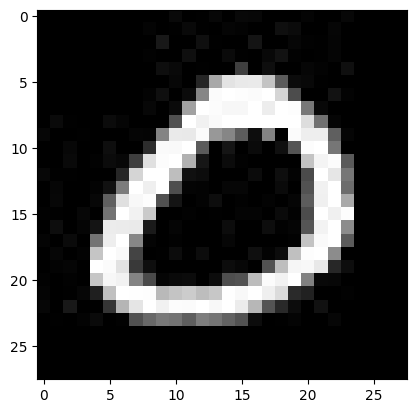

In [ ]:
# проверим, соответствует ли полученное изображение соответствующему классу
img, one_hot_position = train_data[2453]

cls = train_data.classes[one_hot_position]
print(f'Класс: {cls}')
plt.imshow(img, cmap='gray')

In [ ]:
# разобьем датасет на трейновую и валидационную части
train_data, val_data = random_split(train_data, [0.8, 0.2])

In [ ]:
print(f'Длина тренировочных данных: {len(train_data)}')
print(f'Длина валидационных данных: {len(val_data)}')
print(f'Длина тестовых данных: {len(test_data)}')

Длина тренировочных данных: 48000
Длина валидационных данных: 12000
Длина тестовых данных: 10000


In [ ]:
# Разобьем данные на батчи
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

#### Пользовательский класс для задачи регрессии

In [ ]:
# os.listdir('/content/dataset')
len(os.listdir('/content/dataset'))

100001

In [ ]:
class DatasetReg(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform

        self.list_name_file = os.listdir(path)
        if 'coords.json' in self.list_name_file:
            self.list_name_file.remove('coords.json')

        self.len_dataset = len(self.list_name_file)

        with open(os.path.join(self.path, 'coords.json'), 'r') as f:
            self.dict_coords = json.load(f)

    def __len__(self):
        return self.len_dataset

    def __getitem__(self, index):
        name_file = self.list_name_file[index]
        path_img = os.path.join(self.path, name_file)

        img = np.array(Image.open(path_img))
        coord = np.array(self.dict_coords[name_file])

        if self.transform is not None:
            img = self.transform(img)

        return img, coord

In [ ]:
dataset = DatasetReg('/content/dataset')

In [ ]:
len(dataset)

100000

Координаты центра: [30 29]


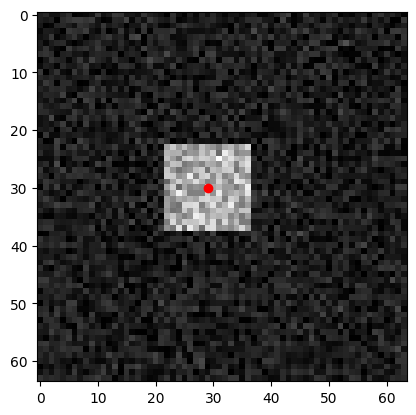

In [ ]:
img, coord = dataset[98850]
print(f'Координаты центра: {coord}')
plt.scatter(coord[1], coord[0], marker='o', color='red')
plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
# разобьем датасет на трейновую и валидационную части
train_set, val_set, test_set = random_split(dataset, [0.7, 0.1, 0.2])

In [ ]:
print(f'Длина тренировочных данных: {len(train_set)}')
print(f'Длина валидационных данных: {len(val_set)}')
print(f'Длина тестовых данных: {len(test_set)}')

Длина тренировочных данных: 70000
Длина валидационных данных: 10000
Длина тестовых данных: 20000


In [ ]:
# Разобьем данные на батчи
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [ ]:
for i, (samples, target) in enumerate(train_loader):
    if i < 3:
        print(f'Номер batch: {i+1}')
        print(f'    размер samples: {samples.shape}')
        print(f'    размер target: {target.shape}')

print('\n    ..........    \n')
print(f'Номер batch: {i+1}')
print(f'    размер samples: {samples.shape}')
print(f'    размер target: {target.shape}')

Номер batch: 1
    размер samples: torch.Size([64, 64, 64])
    размер target: torch.Size([64, 2])
Номер batch: 2
    размер samples: torch.Size([64, 64, 64])
    размер target: torch.Size([64, 2])
Номер batch: 3
    размер samples: torch.Size([64, 64, 64])
    размер target: torch.Size([64, 2])

    ..........    

Номер batch: 1094
    размер samples: torch.Size([48, 64, 64])
    размер target: torch.Size([48, 2])


### Трансформации

#### Imports

In [ ]:
import torch
import torchvision

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder

from torchvision import transforms

# BETA-тестирование, torchvision-0.16
from torchvision.transforms import v2


import os

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

#### Отличия V2 и Transforms

По сути V2 - это переписанный Transforms
- обеспечивает поддержку задач классификации изображений, детекции. сегментации, классификации видео и т.д.;
- поддерживает больше преобразований;
- быстрее;
- поддерживает произвольные структуры ввода;
- будущеие улучшения и фунекции будут добавлены только к V2.

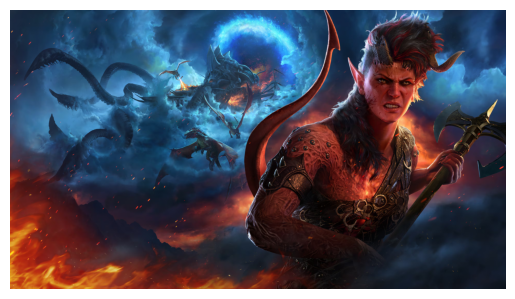

In [ ]:
plt.axis('off')
plt.imshow(Image.open('/content/image_2024-11-23_19-09-24.png'))

In [ ]:
# представим ее в виде массива numpy
img = np.array(Image.open('/content/image_2024-11-23_19-09-24.png'))
print(type(img))
print(img.shape)    # H, W, C
print(img.dtype)
print(f'min = {img.min()}, max = {img.max()}')

<class 'numpy.ndarray'>
(2160, 3840, 3)
uint8
min = 0, max = 255


#### Преобразование изображения при помощи Transforms

Т.к. мы работаем в Pytorch, то все массивы, перед подачей на вход нейронной сети, необходимо преобразовывать в тензоры.

In [ ]:
transform = transforms.ToTensor()
img_ToTensor = transform(img)

print(type(img_ToTensor))
print(img_ToTensor.shape)    # C, H, W
print(img_ToTensor.dtype)
print(f'min = {img_ToTensor.min()}, max = {img_ToTensor.max()}')    # 0.0, 1.0

<class 'torch.Tensor'>
torch.Size([3, 2160, 3840])
torch.float32
min = 0.0, max = 1.0


#### Разбор типовой ошибки.

Нельзя с помощью reshape изменить оси для цветовых каналов!
.reshape просто присвоит нужные значения и перемешает.
Для этого необходимо использовать специальные методы.

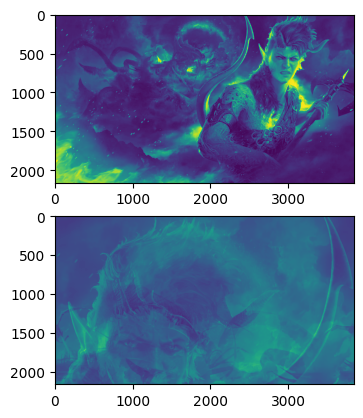

In [ ]:
img_c2 = img
img_c0 = img.reshape([3, 2160, 3840])

_, ax = plt.subplots(2,1)

ax[0].imshow(img_c2[..., 0])
ax[1].imshow(img_c0[0, ...])

#### Нормализация

In [ ]:
transform = transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))

img_norm = transform(img_ToTensor)

print(type(img_norm))
print(img_norm.shape)    # C, H, W
print(img_norm.dtype)
print(f'min = {img_norm.min()}, max = {img_norm.max()}')    # -1.0, 1.0

<class 'torch.Tensor'>
torch.Size([3, 2160, 3840])
torch.float32
min = -1.0, max = 1.0


#### Сборка трансформаций Compose()

Для упрощения работы трансформации можно упаковывать в один "пакет" и применять к большому кол-ву изображений

In [ ]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))

     ]
)

img = transform(Image.open('/content/image_2024-11-23_19-09-24.png'))

print(type(img))
print(img.shape)    # C, H, W
print(img.dtype)
print(f'min = {img.min()}, max = {img.max()}')    # 0.0, 1.0

<class 'torch.Tensor'>
torch.Size([3, 2160, 3840])
torch.float32
min = -1.0, max = 1.0


#### Преобразование изображения при помощи V2

Рассмотрим тебе же самые преобразования в модуле V2

In [ ]:
# Преобразования изображения в torch.tensor().
# (Pil.image, np.array) ==> torch.tensor
# (H,W,C) ==> (C, H, W)
# (0, 255) ==> (0.0, 1.0)

transform = v2.ToTensor()
img_v2 = transform(Image.open('/content/image_2024-11-23_19-09-24.png'))

print(type(img_v2))
print(img_v2.shape)    # C, H, W
print(img_v2.dtype)
print(f'min = {img_v2.min()}, max = {img_v2.max()}')    # 0.0, 1.0

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


<class 'torch.Tensor'>
torch.Size([3, 2160, 3840])
torch.float32
min = 0.0, max = 1.0


In [ ]:
# Преобразования изображения в torchvision.tv_tensors.
# (Pil.image, np.array) ==> torchvision.tv_tensors
# (H,W,C) ==> (C, H, W)
# (0, 255) ==> (0, 255)

transform = v2.ToImage()
img_v2 = transform(Image.open('/content/image_2024-11-23_19-09-24.png'))

print(type(img_v2))
print(img_v2.shape)    # C, H, W
print(img_v2.dtype)    # НЕ ИЗМЕНИЛСЯ
print(f'min = {img_v2.min()}, max = {img_v2.max()}')    # (0, 255)

<class 'torchvision.tv_tensors._image.Image'>
torch.Size([3, 2160, 3840])
torch.uint8
min = 0, max = 255


In [ ]:
# изменение типа данных в V2
transform = v2.ToDtype(torch.float32, scale=True)
img_dtype_v2 = transform(img_v2)

print(type(img_dtype_v2))
print(img_dtype_v2.shape)    # C, H, W
print(img_dtype_v2.dtype)    # torch.float32
print(f'min = {img_dtype_v2.min()}, max = {img_dtype_v2.max()}')    # (0.0, 1.0)

<class 'torchvision.tv_tensors._image.Image'>
torch.Size([3, 2160, 3840])
torch.float32
min = 0.0, max = 1.0


In [ ]:
# нормализация в V2
transform = v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
img_norm_v2 = transform(img_dtype_v2)

print(type(img_norm_v2))
print(img_norm_v2.shape)    # C, H, W
print(img_norm_v2.dtype)    # torch.float32
print(f'min = {img_norm_v2.min()}, max = {img_norm_v2.max()}')    # (-1.0, 1.0)

<class 'torchvision.tv_tensors._image.Image'>
torch.Size([3, 2160, 3840])
torch.float32
min = -1.0, max = 1.0


In [ ]:
# используем все трансформации последовательно
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ]
)


img_v2 = transform(Image.open('/content/image_2024-11-23_19-09-24.png'))

print(type(img_v2))
print(img_v2.shape)
print(img_v2.dtype)
print(f'min = {img_v2.min()}, max = {img_v2.max()}')

<class 'torchvision.tv_tensors._image.Image'>
torch.Size([3, 2160, 3840])
torch.float32
min = -1.0, max = 1.0


#### Шаблон для применения трансформаций
[Преобразования в PyTorch](https://pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended)

In [ ]:
"""
    transform = v2.Compose(
        [
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),

            -- Добавляем различные трансформации--

            v2.ToDtype(torch.float32, scale=True),
            v2.RandomRotation(degrees=(0, 180)),
            v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        ]
    )
"""

'\n    transform = v2.Compose(\n        [\n            v2.ToImage(),\n            v2.ToDtype(torch.float32, scale=True),\n\n            -- Добавляем различные трансформации--\n\n            v2.ToDtype(torch.float32, scale=True),\n            v2.RandomRotation(degrees=(0, 180)),\n            v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))\n        ]\n    )\n'

#### Трансформации для MNIST

Немного исправим нам пользовательский класс. В методе __getitem__
Не будем оборачивать sample в np.array

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform

        self.len_dataset = 0 # длина датасет
        self.data_list = [] # список кортежей путей до файла и позиции в onehot векторе

        # итерируемся по папке с основными файлами
        for path_dir, dir_list, file_list in os.walk(path):
            if path_dir == path:
                self.classes = sorted(dir_list)
                self.class_to_idx = {
                    cls_name: i for i, cls_name in enumerate(self.classes)
                    }
                continue

            cls = path_dir.split('/')[-1]

            for name_file in file_list:
                file_path = os.path.join(path_dir, name_file)
                self.data_list.append((file_path, self.class_to_idx[cls]))

            self.len_dataset += len(file_list)

    def __len__(self):
        return self.len_dataset

    def __getitem__(self, index):
        file_path, target = self.data_list[index]
        sample = Image.open(file_path)

        if self.transform is not None:
            sample = self.transform(sample)

        return sample, target

In [ ]:
# создадим трансформации, которые будем подавать в пользовательский класс
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5), std=(0.5))
    ]
)

In [ ]:
train_data = MNISTDataset('/content/mnist/training', transform=transform)
test_data = MNISTDataset('/content/mnist/testing', transform=transform)

In [ ]:
# возьмем для примера из тестовых данных одно изображение
img, cls = test_data[2]

print('imgs: ')
print(f'    {type(img)}')
print(f'    {img.shape}')
print(f'    {img.dtype}')
print(f'    min = {img.min()}, max = {img.max()}')
print('cls: ')
print(f'    {cls}')

imgs: 
    <class 'torch.Tensor'>
    torch.Size([1, 28, 28])
    torch.float32
    min = -1.0, max = 1.0
cls: 
    5


Воспользуемся трансформациями из модуля V2

In [ ]:
# создадим трансформации, которые будем подавать в пользовательский класс
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.5,), std=(0.5,))
    ]
)

In [ ]:
train_data = MNISTDataset('/content/mnist/training', transform=transform)
test_data = MNISTDataset('/content/mnist/testing', transform=transform)

In [ ]:
# возьмем для примера из тестовых данных одно изображение
img, cls = test_data[2]

print('imgs: ')
print(f'    {type(img)}')
print(f'    {img.shape}')
print(f'    {img.dtype}')
print(f'    min = {img.min()}, max = {img.max()}')
print('cls: ')
print(f'    {cls}')

imgs: 
    <class 'torchvision.tv_tensors._image.Image'>
    torch.Size([1, 28, 28])
    torch.float32
    min = -1.0, max = 1.0
cls: 
    5


In [ ]:
#создаем тренировочные и валидационные данные
train_data, val_data = random_split(train_data,[0.8, 0.2])

In [ ]:
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=16, shuffle=True)

In [ ]:
imgs, cls = next(iter(train_loader))

print('imgs: ')
print(f'    {type(imgs)}')
print(f'    {imgs.shape}')
print(f'    {imgs.dtype}')
print('cls: ')
print(f'    {type(cls)}')
print(f'    {cls.shape}')
print(f'    {cls.dtype}')

imgs: 
    <class 'torch.Tensor'>
    torch.Size([16, 1, 28, 28])
    torch.float32
cls: 
    <class 'torch.Tensor'>
    torch.Size([16])
    torch.int64


##### Использование ImageFolder

При использовании ImageFolder, есть несколько нюансов

In [ ]:
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.Grayscale(), # используем, чтобы был 1 цветовой канал
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.5,), std=(0.5, ))
    ]
)

In [ ]:
train_data = ImageFolder(root='/content/mnist/training', transform=transform)
test_data = ImageFolder(root='/content/mnist/testing', transform=transform)

In [ ]:
# возьмем для примера из тестовых данных одно изображение
img, cls = test_data[200]

print('imgs: ')
print(f'    {type(img)}')
print(f'    {img.shape}')
print(f'    {img.dtype}')
print(f'    min = {img.min()}, max = {img.max()}')
print('cls: ')
print(f'    {cls}')

imgs: 
    <class 'torchvision.tv_tensors._image.Image'>
    torch.Size([1, 28, 28])
    torch.float32
    min = -1.0, max = 0.992156982421875
cls: 
    0


In [ ]:
#создаем тренировочные и валидационные данные
train_data, val_data = random_split(train_data,[0.8, 0.2])

In [ ]:
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=16, shuffle=True)

In [ ]:
imgs, cls = next(iter(train_loader))

print('imgs: ')
print(f'    {type(imgs)}')
print(f'    {imgs.shape}')
print(f'    {imgs.dtype}')
print('cls: ')
print(f'    {type(cls)}')
print(f'    {cls.shape}')
print(f'    {cls.dtype}')

imgs: 
    <class 'torch.Tensor'>
    torch.Size([16, 1, 28, 28])
    torch.float32
cls: 
    <class 'torch.Tensor'>
    torch.Size([16])
    torch.int64


#### Трансформация для задачи регрессии.

Немного исправляем его для работы с тензорами

In [ ]:
class DatasetReg(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform

        self.list_name_file = os.listdir(path)
        if 'coords.json' in self.list_name_file:
            self.list_name_file.remove('coords.json')

        self.len_dataset = len(self.list_name_file)

        with open(os.path.join(self.path, 'coords.json'), 'r') as f:
            self.dict_coords = json.load(f)

    def __len__(self):
        return self.len_dataset

    def __getitem__(self, index):
        name_file = self.list_name_file[index]
        path_img = os.path.join(self.path, name_file)

        img = Image.open(path_img)
        coord = torch.tensor(self.dict_coords[name_file], dtype=torch.float32)

        if self.transform is not None:
            img = self.transform(img)

        return img, coord

In [ ]:
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.5,), std=(0.5, ))
    ]
)

In [ ]:
dataset = DatasetReg(path='/content/dataset', transform=transform)

In [ ]:
img, coord = dataset[2]

print('imgs: ')
print(f'    {type(img)}')
print(f'    {img.shape}')
print(f'    {img.dtype}')
print(f'    min = {img.min()}, max = {img.max()}')
print('coord: ')
print(f'    {type(coord)}')
print(f'    {coord.shape}')
print(f'    {coord.dtype}')

imgs: 
    <class 'torchvision.tv_tensors._image.Image'>
    torch.Size([1, 64, 64])
    torch.float32
    min = -1.0, max = 0.6235295534133911
coord: 
    <class 'torch.Tensor'>
    torch.Size([2])
    torch.float32


In [ ]:
train_set, val_set, test_set = random_split(dataset,[0.7, 0.1, 0.2])

In [ ]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [ ]:
imgs, cords = next(iter(train_loader))

print('imgs: ')
print(f'    {type(imgs)}')
print(f'    {imgs.shape}')
print(f'    {imgs.dtype}')
print('cords: ')
print(f'    {type(cords)}')
print(f'    {cords.shape}')
print(f'    {cords.dtype}')

imgs: 
    <class 'torch.Tensor'>
    torch.Size([32, 1, 64, 64])
    torch.float32
cords: 
    <class 'torch.Tensor'>
    torch.Size([32, 2])
    torch.float32


#### Создание собственного класса трансформации

Если среди реализованных трансформаций нет подходящей, то возможно создать свою.
Разберем это на примере трансформации Normalize

In [ ]:
class MyTransform(torch.nn.Module):
    def forward(self, sample):
        pass

In [ ]:
class MyNormalize(torch.nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean
        self.std = std
    # в методе forward прописывается логика преобразований
    def forward(self, sample):
        sample = (sample - self.mean) / self.std  # реализация нормализации

        return sample

In [ ]:
transform_1 = transforms.Compose(
    [
        v2.ToTensor(),
        v2.Normalize(mean=(0.5, ), std=(0.5, ))
    ]
)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
transform_2 = transforms.Compose(
    [
        transforms.ToTensor(),
        MyNormalize(0.5, 0.5)
    ]
)

In [ ]:
img = Image.open('/content/image_2024-11-23_19-09-24.png')

In [ ]:
img_1 = transform_1(img)

print('img_1: ')
print(f'    {type(img_1)}')
print(f'    {img_1.shape}')
print(f'    {img_1.dtype}')
print(f'    min = {img_1.min()}, max = {img_1.max()}')

img_1: 
    <class 'torch.Tensor'>
    torch.Size([3, 2160, 3840])
    torch.float32
    min = -1.0, max = 1.0


In [ ]:
img_2 = transform_2(img)

print('img_2: ')
print(f'    {type(img_2)}')
print(f'    {img_2.shape}')
print(f'    {img_2.dtype}')
print(f'    min = {img_2.min()}, max = {img_2.max()}')

img_2: 
    <class 'torch.Tensor'>
    torch.Size([3, 2160, 3840])
    torch.float32
    min = -1.0, max = 1.0


In [ ]:
img_1 == img_2

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]]

In [ ]:
torch.equal(img_1, img_2)

True